In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pdf
import scipy.stats
import numpy as np
import pandas as pd
import colors as EL

In [2]:
df = pd.read_csv('./data/trajectories/cleaned_animal_analyses_experiment.csv')
df = df[df['dead'] != 'yes']

animals = df["animal_ID"].unique()
# Check that animal IDs in dataframe are unique
assert len(df) == len(animals)

display(df.head())

,A_c_speed,A_discovery_time,A_median_conc,animal_ID,E_c_speed,E_discovery_time,E_median_conc,dead,sex,species,treatment_odor,median_conc_diff,discovery_time_diff,c_speed_diff
0,-0.013474,0.075000,4.957667,190626-01-top,-0.008422,0.750000,15.134000,no,f,Aedes aegypti,100ul_milliQ_water,10.176333,0.675000,0.005052
1,-0.058355,0.833333,6.024708,190626-01-bottom,-0.070911,0.016667,15.773792,no,f,Aedes aegypti,100ul_milliQ_water,9.749083,-0.816667,-0.012556
2,0.006698,0.908333,64.677917,190626-02-top,-0.017166,0.016667,54.137708,no,m,Aedes aegypti,100ul_milliQ_water,-10.540208,-0.891667,-0.023863
3,0.063251,0.558333,5.917708,190626-02-bottom,0.083160,11.608333,1.802208,no,m,Aedes aegypti,100ul_milliQ_water,-4.115500,11.050000,0.019909
4,0.000796,0.016667,1.961500,190626-03-top,-0.079610,15.000000,1.638667,missing,missing,Aedes aegypti,100ul_milliQ_water,-0.322833,14.983333,-0.080406


In [3]:
# Split dataframe by species

aegypti = df[df['species'].str.upper() == 'AEDES AEGYPTI'].copy()
albopictus = df[df['species'].str.upper() == 'AEDES ALBOPICTUS'].copy()
arabiensis = df[df['species'].str.upper() == 'ANOPHELES ARABIENSIS'].copy()
coluzzii = df[df['species'].str.upper() == 'ANOPHELES GAMBIAE'].copy()
quinque = df[df['species'].str.upper() == 'CULEX QUINQUEFASCIATUS'].copy()
tarsalis = df[df['species'].str.upper() == 'CULEX TARSALIS'].copy()

checks = ['time_near_stim', 'discovery_time']

In [4]:
def plot_values_species(value, savename, ylim=None, xlim=None, 
                        verbose=False, singlestats=True, ylabel="", ylimticks=[]):
    print(value)
    labels = ['Water', 'Quinine', 'Food']
    s_labels = ['aegypti', 'albopictus', 'arabiensis', 'coluzzii', 'culex_q', 'culex_t']
    
    species = [aegypti, albopictus, arabiensis, coluzzii, quinque, tarsalis]
    colors = [EL.aegypti, EL.albopictus, EL.arabiensis, 
              EL.coluzzii, EL.culex_q, EL.culex_t]
    
    fig = plt.figure(figsize=(6*1.65, 2.5))

    for ii, specie in enumerate(species): 
        color = colors[ii]
        ax = fig.add_subplot(1, 6, ii+1)
                
        water = specie[specie['treatment_odor'] == '100ul_milliQ_water']
        quinine = specie[specie['treatment_odor'] == '100ul_quinine']
        food = specie[specie['treatment_odor'] == '05_percent_food']

        water = water[value].tolist()
        quinine = quinine[value].tolist()
        food = food[value].tolist()

        # TEMPORARY while experiments are not done
        if len(water) == 0:
            water = [0]
        if len(quinine) == 0:
            quinine = [0]
        if len(food) == 0:
            food = [0]

        water = [x for x in water if str(x) != 'nan']
        quinine = [x for x in quinine if str(x) != 'nan']
        food = [x for x in food if str(x) != 'nan']

        data = [water, quinine, food]
        parts = ax.violinplot(data, showmeans=False, showmedians=False, showextrema=False)
        jitter = [np.random.normal(scale=0.1, size=len(water)), 
                  np.random.normal(scale=0.1, size=len(quinine)),
                  np.random.normal(scale=0.1, size=len(food))]

        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(color)
            pc.set_alpha(0.25)

        for i, (j, d) in enumerate(zip(jitter, data)):
            j = [x+i+1 for x in j]
            ax.scatter(j, d, alpha=0.75, color=color, zorder=5, s=12, 
                        marker='o', clip_on=False, lw=0)

        if xlim != None: 
            ax.set_xlim(*xlim)
        if ylim != None: 
            ax.set_ylim(*ylim)
            
        if len(ylimticks)>0: 
            ax.set_yticks(ylimticks)
        
        if color == colors[0]:
            ax.set_ylabel(ylabel)

        # X axis labels
        ax.axhline(y=0, xmin=0, xmax=1, color='k', alpha=0.5, zorder=50)
        ax.set_xlim(0.25, 3.75)
        ax.set_xticks(np.arange(1, 4, 1))
        ax.set_xticklabels(labels)
        ax.xaxis.set_ticks_position('none') 
        ax.tick_params(axis='x', which='major', pad=10)

        # Add a black bar for the mean of each dataset
        ch = 0.1
        if verbose == True:
            print('\n', s_labels[ii])
            
        label = ['water', 'quinine', 'food']
        waterdatum = np.mean(water)
        for i, datum in enumerate(data):
            if i > 0:
                print(s_labels[ii], label[i], np.mean(datum)-waterdatum)
            # Plot the mean as a horizontal black bar
            ax.plot([i+1-ch, i+1+ch], [np.mean(datum)]*2, color="k", 
                    alpha=0.75, lw=2, zorder=20, clip_on=False, solid_capstyle='round')
            # Plot the standard error as a vertical black bar from the mean
            # sem = scipy.stats.sem(datum)
            # ax.plot([i+1, i+1],[np.mean(datum)+sem, np.mean(datum)-sem],
            #        color = "k", alpha=0.5, lw=2, zorder=20, clip_on=False, solid_capstyle='round')
            # Plot the median as a black scatterpoint
            # ax.scatter([i+1], np.median(datum), color="k", lw=0, alpha=0.75, zorder=20, clip_on=False)
            if verbose == True:
                print(labels[i], 'mean:', np.mean(datum), 'n:', len(datum))

        # Plot statistical significance bar for each plot
        up, ch, bit = ax.get_ylim()[1]*1.05, ax.get_ylim()[1]*0.075, 0.1
        if singlestats == False:
            ax.plot([1-bit, 3+bit], [up, up], color="k", lw=1, clip_on=False, alpha=0.5)
            ax.plot([1-bit, 2+bit], [up+ch, up+ch], color="k", lw=1, clip_on=False, alpha=0.5)
        else:
            ax.plot([1-bit, 3+bit], [up+ch, up+ch], color="k", lw=1, clip_on=False, alpha=0.5)

        # Edit plot borders
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ii == 0:
            ax.spines['left'].set_linewidth(1)
            ax.tick_params(axis='y', which='major', length=6, width=1, labelsize='large')
        else: 
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])
            ax.set_yticklabels([])
            
    # Export text as editable text instead of shapes:
    matplotlib.rcParams['pdf.fonttype'] = 42

    # Preserve the vertical order of embedded images:
    matplotlib.rcParams['image.composite_image'] = False

    # Remove padding and margins from the figure and all its subplots
    plt.margins(0,0)
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

    # Save the Matplotlib figure as a PDF file:
    pp = pdf.PdfPages(savename, keep_empty=False)
    pp.savefig(fig)
    pp.close()
    plt.show()

median_conc_diff
aegypti quinine -8.650103680555556
aegypti food 19.830118303571428
albopictus quinine -14.869713210702342
albopictus food 27.71164270421607
arabiensis quinine -6.607515764687103
arabiensis food 12.950866841133005
coluzzii quinine -6.443382290184922
coluzzii food 7.317562666135034
culex_q quinine 0.7975761542792803
culex_q food 17.2602616025116
culex_t quinine -1.3137703703703711
culex_t food 16.284723379629632


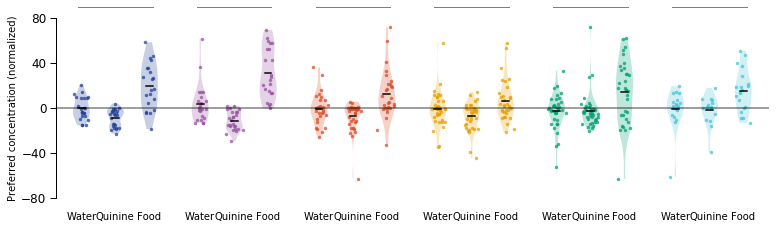

discovery_time_diff
aegypti quinine 1.2806111111111107
aegypti food -0.47003968253968287
albopictus quinine 1.1105072463768115
albopictus food 0.5173254281949933
arabiensis quinine -2.489375798212005
arabiensis food -0.1855398193760256
coluzzii quinine -2.027803461356093
coluzzii food 1.4613038277511956
culex_q quinine 0.11650900900900929
culex_q food 0.9362817362817362
culex_t quinine 0.2612962962962958
culex_t food 0.8311574074074075


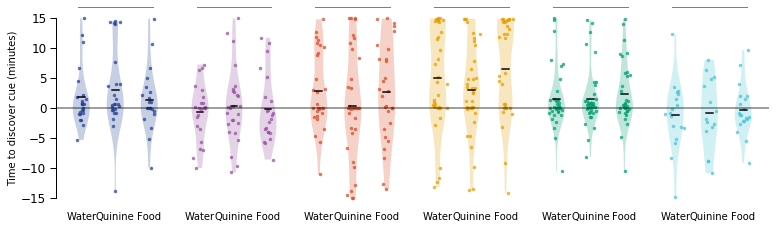

c_speed_diff
aegypti quinine 0.057983715870013094
aegypti food -0.00900941207833289
albopictus quinine 0.09510959120206885
albopictus food -0.03523897188312317
arabiensis quinine 0.03274335572883097
arabiensis food -0.014590525044377807
coluzzii quinine 0.017699594315253978
coluzzii food 0.0016213346989154716
culex_q quinine 0.014262287541880218
culex_q food -0.016240244240517836
culex_t quinine 0.022469572066592735
culex_t food 0.016342529222660003


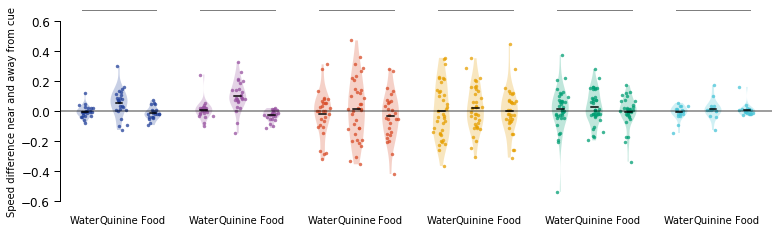

In [5]:
plot_values_species('median_conc_diff', './figures/E_time_move.pdf', 
                    ylim=(-80, 80), ylimticks=np.arange(-80, 81, 40),
                    ylabel="Preferred concentration (normalized)")
plot_values_species('discovery_time_diff', './figures/E_discovery_time.pdf', 
                    ylim=(-15, 15),
                    ylabel="Time to discover cue (minutes)")
plot_values_species('c_speed_diff', './figures/E_c_speed.pdf', 
                    ylim=(-0.6, 0.6), 
                    ylabel="Speed difference near and away from cue")